<a href="https://colab.research.google.com/github/lisamadeddu/lisa-PRA3024/blob/main/GW_tutorial_2_detector_noise_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [2]:
!pip install pycbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [3]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd
import pylab
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.11/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [4]:
m = Merger('GW150914')
ifo = 'L1'
data = m.strain(ifo)

**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them.

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

In [5]:
# duration of data segment
duration=data.duration
print("Duration:", duration, "seconds")

# sampling rate of detector data: how many samples per second are recorded by detector
sample_rate=data.sample_rate
print("Sampling rate:", sample_rate, "Hz")

# total number of data points
n_points=len(data)
print("Number of data points:", n_points)

# frequency resolution: spacing between frequency bins
delta_f=1.0/duration
print("Delta f:", delta_f, "Hz")

# time resolution: spacing between consecutive samples
delta_t=1.0/sample_rate
print("Delta t:", delta_t, "seconds")

# calculate quantity for N (inverse f product of delta_t and delta_f)
N=1/(data.delta_t*data.delta_f)
N,data.shape[0]


Duration: 32.0 seconds
Sampling rate: 4096.0 Hz
Number of data points: 131072
Delta f: 0.03125 Hz
Delta t: 0.000244140625 seconds


(131072.0, 131072)

The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

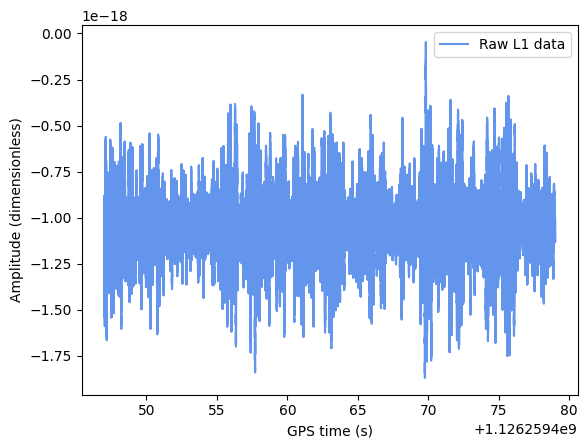

In [6]:
# plot raw detector data
plt.plot(data.sample_times, data, label='Raw L1 data', color='cornflowerblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton.

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design.

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency.

_Hint_: Note that the PSD is a frequency series.

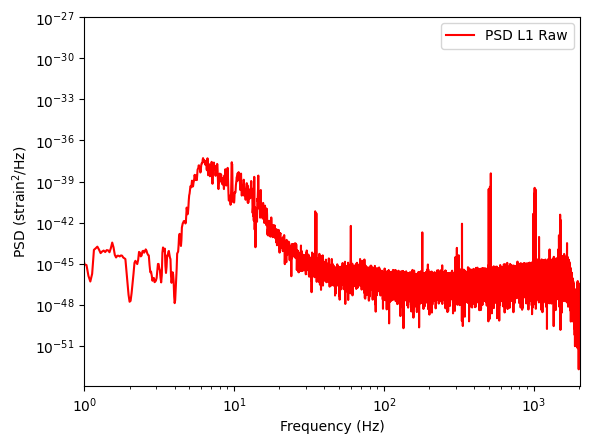

In [7]:
# set lower frequency cutoff for PSD estimation
flow=1 # only frequencies above 1 Hz are considered --> below 1 Hz is poor

# estimate PSD of rate data
# data.filter_psd calculates PSD over entire data as well as delta_f (data.delta_f)
psd=data.filter_psd(data.duration,data.delta_f,flow=flow)

# plots PSD on logarithmic scale for both axes
plt.loglog(psd.get_sample_frequencies(),psd,label='PSD L1 Raw',color='red')
plt.xlim(flow,data.sample_rate/2) # x-axis ranges from 1 Hz to Nyquist (half sampling rate)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (strain$^2$/Hz)')
plt.legend()
plt.show()


The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`.

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


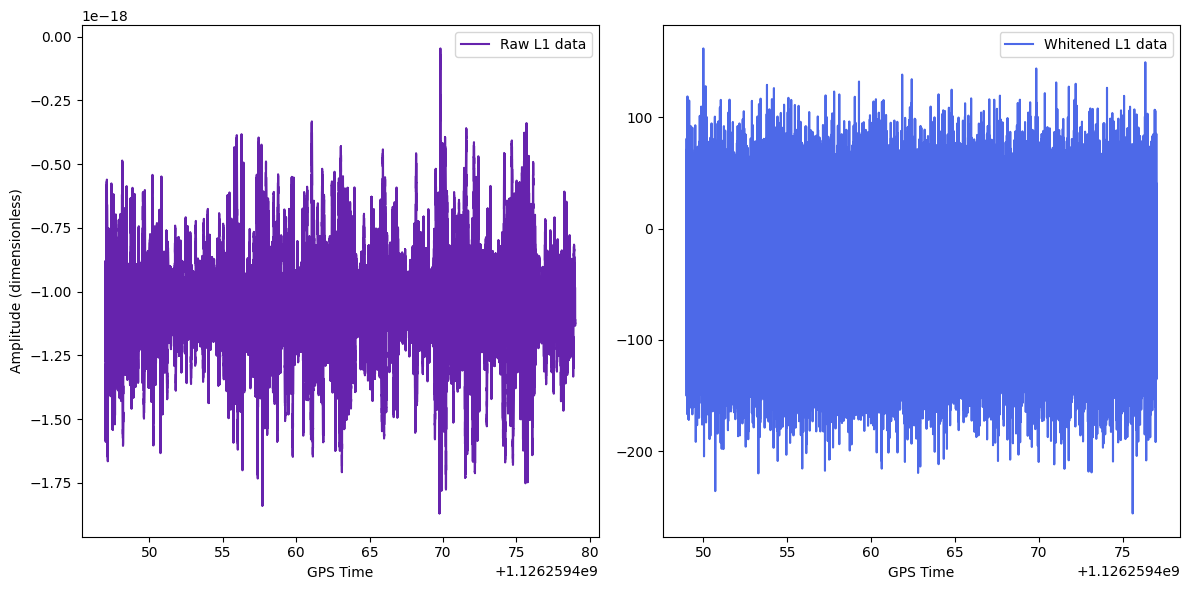

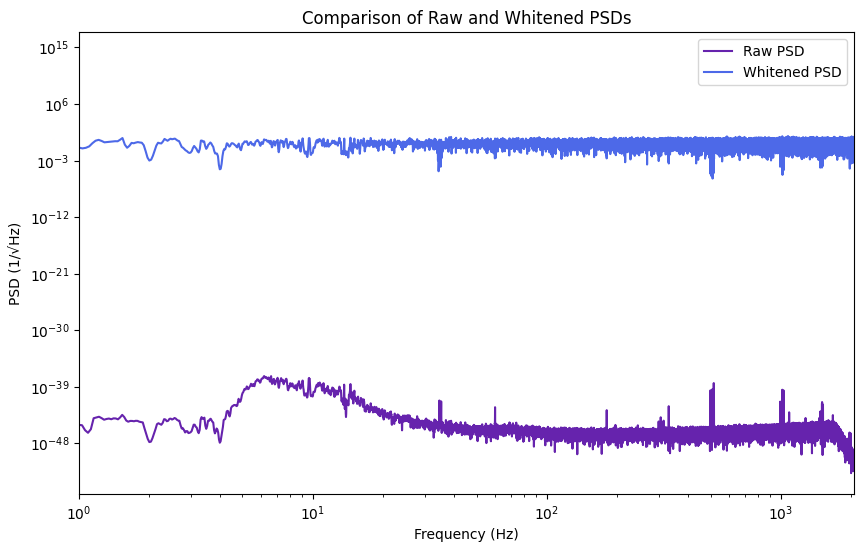

In [9]:
# whiten raw data using segment duration of 4 seconds and max filter duration of 4 seconds
whitened_data=data.whiten(4,4) # whitening: reduces frequency-dependent noise and removes correlation or dependencies (from source see below)

# calculate PSD of whitened data, estimated over entire data with frequency resolution of whitened_data.delta_f
psd_whiten=whitened_data.filter_psd(whitened_data.duration,whitened_data.delta_f,flow=1)

# plot raw data
fig=plt.figure(figsize=(12,6)) # creates figure to plot side-by-side
plt.subplot(1,2,1) # plots on left subplot
plt.plot(data.sample_times,data,label='Raw L1 data', color='#6623ad')
plt.xlabel('GPS Time')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

# plot whitened data
plt.subplot(1,2,2) # plots on right subplot
plt.plot(whitened_data.sample_times,whitened_data,label='Whitened L1 data', color='#4d69e8')
plt.tight_layout() # avoid subplots overlapping
plt.legend()
plt.xlabel('GPS Time')
plt.show()

# calcukate PSD of raw data to compare
raw_psd=data.filter_psd(data.duration,data.delta_f,flow=1)
# plot new raw PSD
plt.figure(figsize=(10,6)) # plots on a new figure

# plot raw PSD on logarithmic scale
plt.loglog(raw_psd.sample_frequencies,raw_psd,label='Raw PSD', color='#6623ad')
# plot PSD of whitened data on same graph with logarithmic scale
plt.loglog(psd_whiten.sample_frequencies,psd_whiten,label='Whitened PSD', color='#4d69e8')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (1/√Hz)')
plt.xlim(flow,data.sample_rate/2)
plt.title('Comparison of Raw and Whitened PSDs')
plt.legend()
plt.show()

source for whitening data: https://learndataa.com/2020/09/15/data-preprocessing-whitening-or-sphering-in-python/


Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data.


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

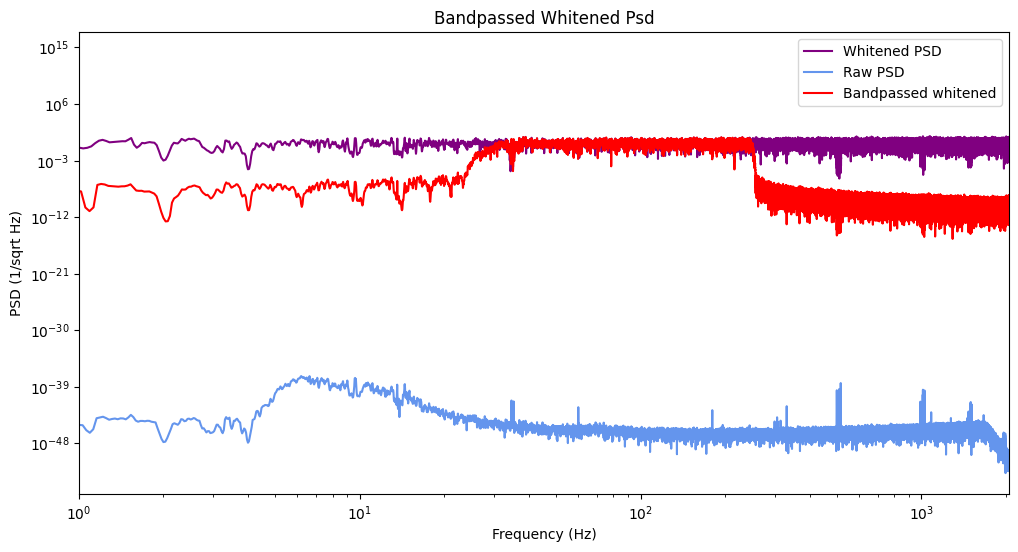

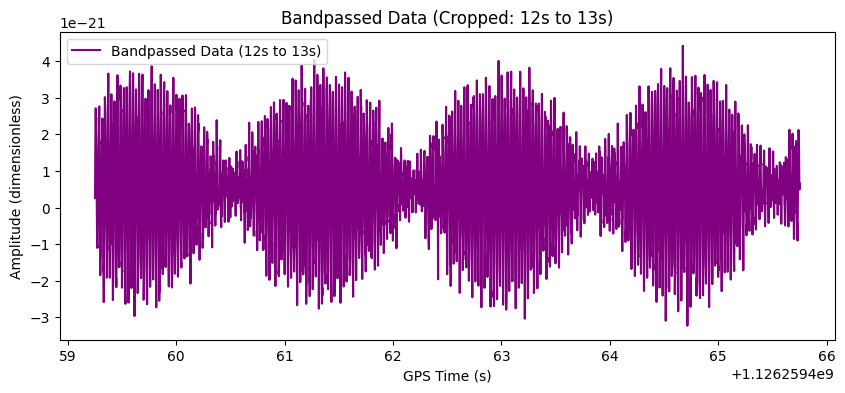

In [ ]:
from pycbc.filter import highpass, lowpass

# define parameters for bandpass filtering
flow = 1
lowpass = 250 # removes noise above 250 Hz
highpass = 30 # removes noise below 30 Hz
order = 512 # set filter order (number of coefficients) used in filters (from ChatGPT)

# apply highpass and lowpass filters
bandpassed_data = data.highpass_fir(highpass, order).lowpass_fir(lowpass, order)
# calculate PSD of bandpassed raw data
psdbandpass = bandpassed_data.filter_psd(bandpassed_data.duration, bandpassed_data.delta_f, flow)
# apply same bandpass filtering to whitened data
white_bandpassed_data = whitened_data.highpass_fir(highpass, order).lowpass_fir(lowpass, order)
# calculate PSD of bandpassed whitened data
white_psdbandpass = white_bandpassed_data.filter_psd(white_bandpassed_data.duration, white_bandpassed_data.delta_f, flow)
# calculate PSD for complete raw and whitened data (no bandpassing)
raw_psd = data.filter_psd(data.duration, data.delta_f, flow)
white_psd = whitened_data.filter_psd(whitened_data.duration, whitened_data.delta_f, flow)

# plotting
plt.figure(figsize=(12,6))
# plot PSD for whitened data
plt.loglog(psd_whiten.sample_frequencies, psd_whiten, label="Whitened PSD", color='purple')
plt.xlim(flow, data.sample_rate/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (1/√Hz)")
plt.title("Whitened PSD")
# plot raw PSD
plt.loglog(raw_psd.sample_frequencies, raw_psd, label="Raw PSD", color='cornflowerblue')
plt.xlim(flow, data.sample_rate/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (1/√Hz)")
plt.title("Raw PSD")
# plot PSD of bandpassed raw data
#plt.loglog(psdbandpass.sample_frequencies, psdbandpass, label="Bandpassed raw")
#plt.xlim(flow, data.sample_rate/2)
#plt.xlabel("Frequency (Hz)")
#plt.ylabel("PSD (1/√Hz)")
#plt.title("Bandpassed Raw PSD")
# plot PSD of bandpassed whitened data
plt.loglog(white_psdbandpass.sample_frequencies, white_psdbandpass, label="Bandpassed whitened", color='red')
plt.xlim(flow, data.sample_rate/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (1/√Hz)")
plt.title("Bandpassed Whitened PSD")
plt.legend()

# removes 12 seconds from start and 13 seconds from end of bandpassed data
cropped_bandpassed=bandpassed_data.crop(12,13)
# plot croppped bandpassed data
plt.figure(figsize=(10,4))
plt.plot(cropped_bandpassed.sample_times,cropped_bandpassed,label='Bandpassed Data (12s to 13s)', color='purple')
plt.xlabel('GPS Time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.title('Bandpassed Data (Cropped: 12s to 13s)')
plt.legend()
plt.show()

**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

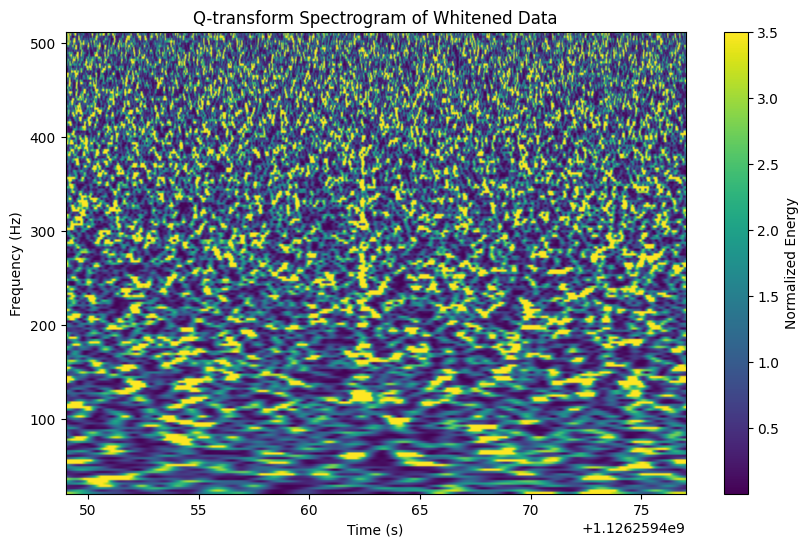

In [ ]:
# compute q-tranfrom of whitened data
# qtransform function returns 3 arrays: times, frequencies, and qplane (2D array
# representing time-frequency energy distribution) (ChatGPT)
times, freqs, qplane = whitened_data.qtransform(delta_t=whitened_data.delta_t,
                                                logfsteps=200, # 200 logarithmically spaced frequency steps
                                                frange=(20, 512), # frequency range from 20Hz-512Hz
                                                qrange=(110, 110), # q-factor = 100
                                                mismatch=0.2, # allow mismatch of 0.2 btw frequency tiles
                                                return_complex=False) # return real values, normalized power

# define extent of image for plotting
# x-axis spans from first time val to last time val, y-axis spans from lowest frequency to highest
extent = [times[0], times[-1], freqs[0], freqs[-1]]

plt.figure(figsize=(10, 6))
# display q-transform using imshow
im = plt.imshow(qplane, aspect='auto', origin='lower', extent=extent,
                cmap='viridis', vmax=3.5) # origin is let to lower so that lowest frequency appears at bottom (ChatGPT)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Q-transform Spectrogram of Whitened Data')
plt.colorbar(im, label='Normalized Energy') # color bar shows scale of normalized energy
plt.show()


As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


Good job! This is the end of the second part. Maybe you can go for a break?